In [1]:
import spacy

from senticnet import senticnet
from spacy import displacy
from spacy.matcher import DependencyMatcher

In [2]:
nlp = spacy.load("en_core_web_sm")

In [3]:
pattern = [
  {
    "RIGHT_ID": "interviewee",       
    "RIGHT_ATTRS": {"LOWER": {"IN": ["i", "me", "my", "mine", "myself"]}}
  },
  {
    "LEFT_ID": "interviewee",
    "REL_OP": "<<",
    "RIGHT_ID": "interviewee parent",
    "RIGHT_ATTRS": {},
  },
  {
    "LEFT_ID": "interviewee parent",
    "REL_OP": ">>",
    "RIGHT_ID": "description",
    "RIGHT_ATTRS": {"POS": {"IN": ["ADJ", "ADV", "INTJ", "NOUN", "VERB"]}},
  }
]

matcher = DependencyMatcher(nlp.vocab)
matcher.add("interviewee", [pattern])

In [4]:
def process_sentence(sent: str):
    doc = nlp(sent)

    matches = matcher(doc)

    positivity = 0.0
    negativity = 0.0

    for match in matches:
        for i in range(1, len(match[1])):
            if doc[match[1][i]].lemma_ in senticnet.senticnet:
                _, _, _, _, _, _, polarity_label, polarity_value, _, _, _, _, _ = senticnet.senticnet[doc[match[1][i]].lemma_]
                if polarity_label == 'positive':
                    positivity += polarity_value
                else:
                    negativity += polarity_value

    inner = 0
    outer = 0

    for sent in doc.sents:
        for word in sent:
            if word.dep_ == 'nsubj' or word.dep_ == 'poss' or word.dep_ == 'attr':
                if (word.pos_ == 'NOUN' or word.pos_ == 'PROPN') and word.dep_ != 'nsubjpass':
                    outer += 1
                elif word.pos_ == 'PRON':
                    if word.morph.get('Person') == ['1']:
                        inner += 1
                    else:
                        outer += 1
            elif word.dep_ == 'dobj' or word.dep_ == 'iobj':
                if word.pos_ == 'NOUN' or word.pos_ == 'PROPN':
                    inner += 1
                elif word.pos_ == 'PRON':
                    if 'Person' in word.morph and word.morph.get('Person')[0] == '1':
                        outer += 1
                    else:
                        inner += 1

    return ' '.join([token.lemma_ for token in doc if not token.is_punct and not token.is_digit and (token.text.lower() == 'i' or not token.is_stop)]), positivity, negativity, inner, outer, inner / max(outer, 1), positivity * (inner - outer)
    # return (positivity, negativity, inner, outer, inner / max(outer, 1), positivity * (inner - outer))
    

In [2]:
import pandas as pd

df = pd.read_csv('data/data.csv')

df.loc[df['ref'].str[0] == 'm', 'ref'] = 0 # neutral
df.loc[df['ref'].str[0] == 'i', 'ref'] = 1 # internal
df.loc[df['ref'].str[0] == 'e', 'ref'] = -1 # external
df = df.astype({'ref': 'int32'})

In [8]:
df[['lemmas', 'pos', 'neg', 'ext', 'int', 'in/out', 'ass_score']] = df['phrase'].apply(lambda x: pd.Series(process_sentence(x)))

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


train_data, test_data, ref_train, ref_test = train_test_split(df[['lemmas', 'pos', 'neg', 'ext', 'int', 'in/out', 'ass_score']], df.ref, test_size=0.2, random_state=42)

tf_idf_vectorizer = TfidfVectorizer()
tf_idf_train = tf_idf_vectorizer.fit_transform(train_data.lemmas)
tf_idf_test = tf_idf_vectorizer.transform(test_data.lemmas)

tf_idf_train_df = pd.DataFrame(tf_idf_train.toarray(), columns=tf_idf_vectorizer.get_feature_names_out())
train_features = pd.concat([tf_idf_train_df, train_data[['pos', 'neg', 'ext', 'int', 'in/out', 'ass_score']].reset_index()], axis=1)
train_features.drop('index', axis=1, inplace=True)

tf_idf_test_df = pd.DataFrame(tf_idf_test.toarray(), columns=tf_idf_vectorizer.get_feature_names_out())
test_features = pd.concat([tf_idf_test_df, test_data[['pos', 'neg', 'ext', 'int', 'in/out', 'ass_score']].reset_index()], axis=1)
test_features.drop('index', axis=1, inplace=True)

svm = SVC(random_state=42)
svm.fit(train_features.values, ref_train.values)

ref_pred = svm.predict(test_features.values)

print(classification_report(ref_pred, ref_test))

              precision    recall  f1-score   support

          -1       0.26      0.46      0.33        68
           0       0.85      0.54      0.66       329
           1       0.20      0.41      0.27        68

    accuracy                           0.51       465
   macro avg       0.44      0.47      0.42       465
weighted avg       0.67      0.51      0.56       465



In [52]:
from sklearn.model_selection import train_test_split

train_data, test_data, ref_train, ref_test = train_test_split(df[['lemmas', 'pos', 'neg', 'ext', 'int', 'in/out', 'ass_score']], df.ref, test_size=0.2, random_state=42)
train_data, val_data, ref_train, ref_val = train_test_split(train_data, ref_train, test_size=0.2, random_state=42)

In [53]:
train_data.shape, val_data.shape, test_data.shape

((1484, 7), (372, 7), (465, 7))

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vectorizer = TfidfVectorizer()
tf_idf_train = tf_idf_vectorizer.fit_transform(train_data.lemmas)
tf_idf_val = tf_idf_vectorizer.transform(val_data.lemmas)
tf_idf_test = tf_idf_vectorizer.transform(test_data.lemmas)

tf_idf_train_df = pd.DataFrame(tf_idf_train.toarray(), columns=tf_idf_vectorizer.get_feature_names_out())
train_features = pd.concat([tf_idf_train_df, train_data[['pos', 'neg', 'ext', 'int', 'in/out', 'ass_score']].reset_index()], axis=1)
train_features.drop('index', axis=1, inplace=True)

tf_idf_val_df = pd.DataFrame(tf_idf_val.toarray(), columns=tf_idf_vectorizer.get_feature_names_out())
val_features = pd.concat([tf_idf_val_df, val_data[['pos', 'neg', 'ext', 'int', 'in/out', 'ass_score']].reset_index()], axis=1)
val_features.drop('index', axis=1, inplace=True)

tf_idf_test_df = pd.DataFrame(tf_idf_test.toarray(), columns=tf_idf_vectorizer.get_feature_names_out())
test_features = pd.concat([tf_idf_test_df, test_data[['pos', 'neg', 'ext', 'int', 'in/out', 'ass_score']].reset_index()], axis=1)
test_features.drop('index', axis=1, inplace=True)

In [37]:
import optuna

from sklearn.metrics import f1_score
from sklearn.svm import SVC


def objective(trial):
    C = trial.suggest_float('C', 1e-3, 10)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    svm = SVC(C=C, kernel=kernel, random_state=42)
    svm.fit(train_features.values, ref_train.values)
    ref_pred = svm.predict(val_features.values)
    return f1_score(ref_pred, ref_val, average='micro')

In [38]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)

study.optimize(objective, n_trials=500)

# print(f'finished {len(study.trials)} trials')
# print('optimal C:', study.best_params['C'])
# print(f'best f1 score: {study.best_value}')

In [34]:
study.best_params['C'], study.best_params['kernel']

(0.7721440882956117, 'linear')

In [41]:
svm = SVC(C=study.best_params['C'], kernel=study.best_params['kernel'], random_state=42)
svm.fit(train_features.values, ref_train.values)

ref_pred = svm.predict(test_features.values)

In [32]:
from sklearn.metrics import classification_report

print(classification_report(ref_pred, ref_test))

              precision    recall  f1-score   support

          -1       0.77      0.78      0.77       117
           0       0.88      0.79      0.83       234
           1       0.64      0.76      0.69       114

    accuracy                           0.78       465
   macro avg       0.76      0.78      0.77       465
weighted avg       0.79      0.78      0.78       465



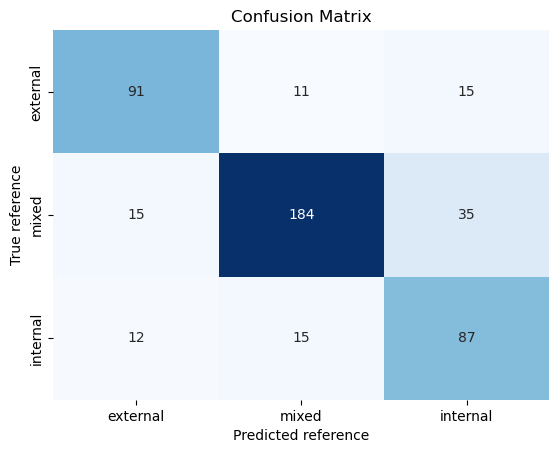

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(ref_pred, ref_test, labels=[-1, 0, 1])

sns.heatmap(confusion, annot=True, fmt='d', cmap="Blues", cbar=False, xticklabels=['external', 'mixed', 'internal'], yticklabels=['external', 'mixed', 'internal'])
plt.title('Confusion Matrix')
plt.ylabel('True reference')
plt.xlabel('Predicted reference')
plt.show()

In [58]:
import joblib
joblib.dump(svm, 'model/svm_model.pkl')
joblib.dump(tf_idf_vectorizer, 'model/vectorizer.pkl')

['vectorizer.pkl']